C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


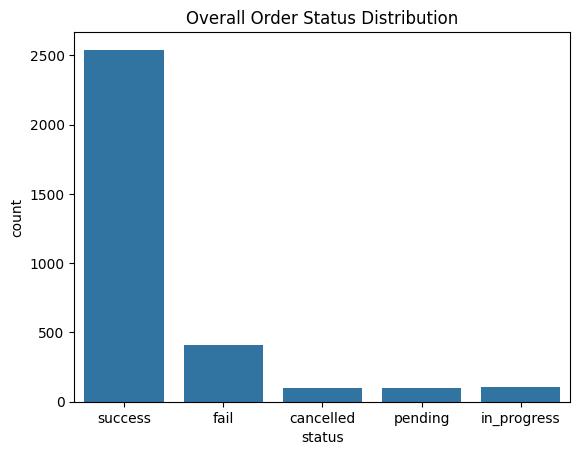

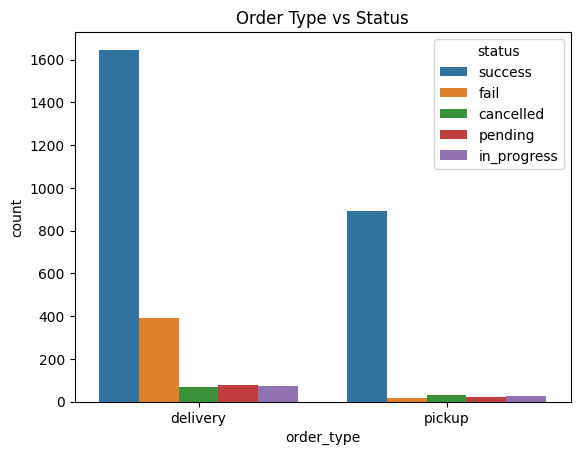

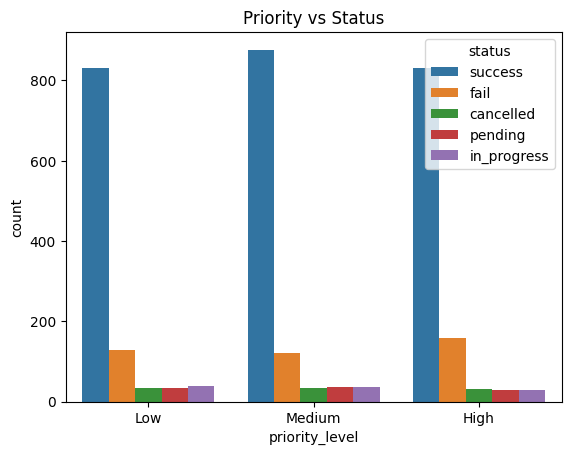

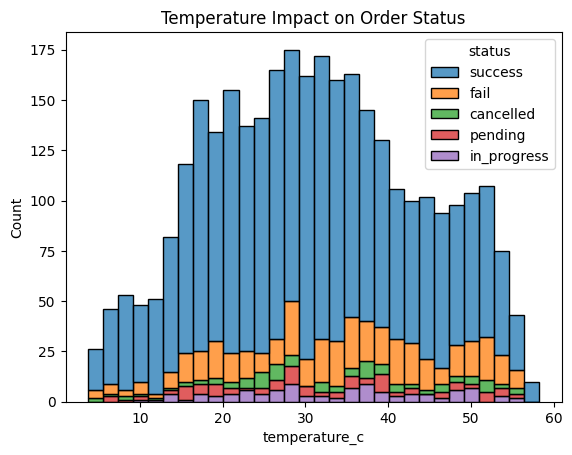

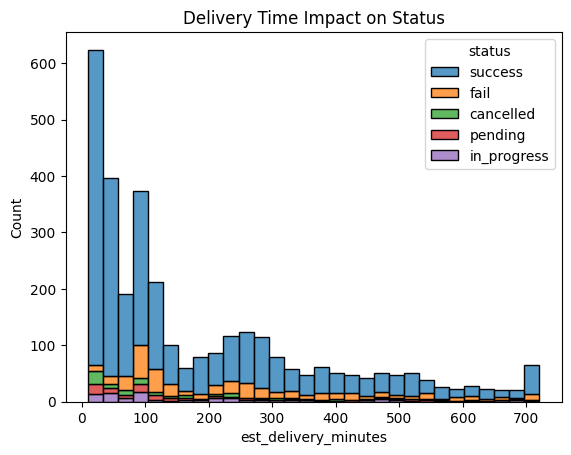

C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_temp = df.groupby('temp_bucket')['status'].apply(lambda s:(s=="success").mean())
C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_time = df.groupby('time_bucket')['status'].apply(lambda s:(s=="success").mean())


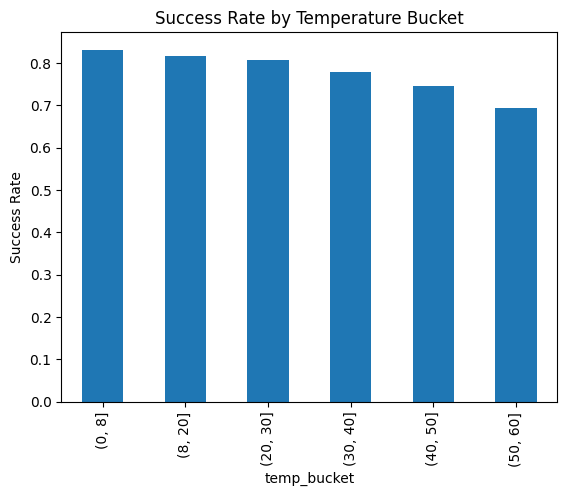

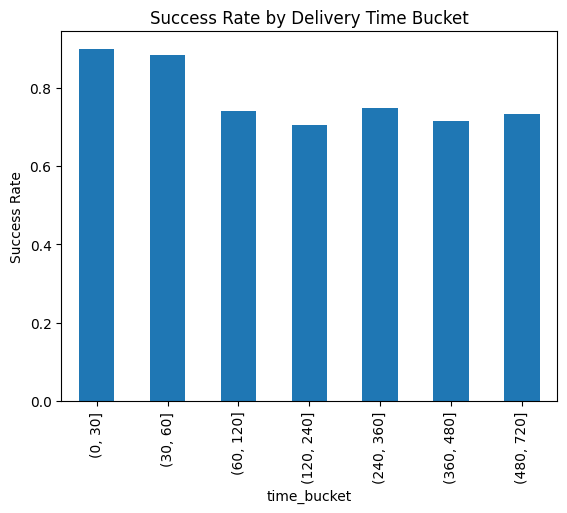

C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fail_rate_temp = df.groupby('temp_bucket')['status'].apply(lambda s:(s=="fail").mean())
C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fail_rate_time = df.groupby('time_bucket')['status'].apply(lambda s:(s=="fail").mean())


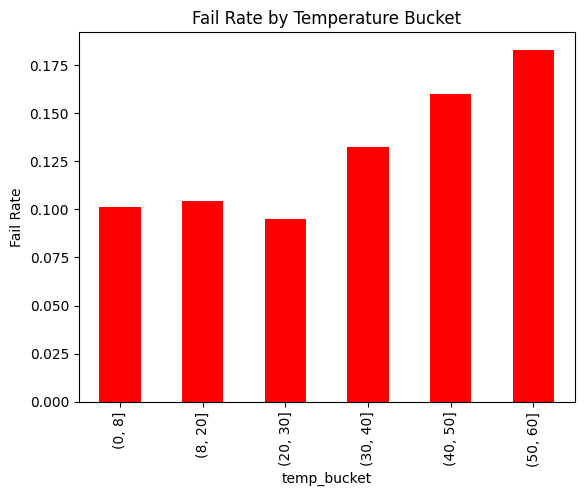

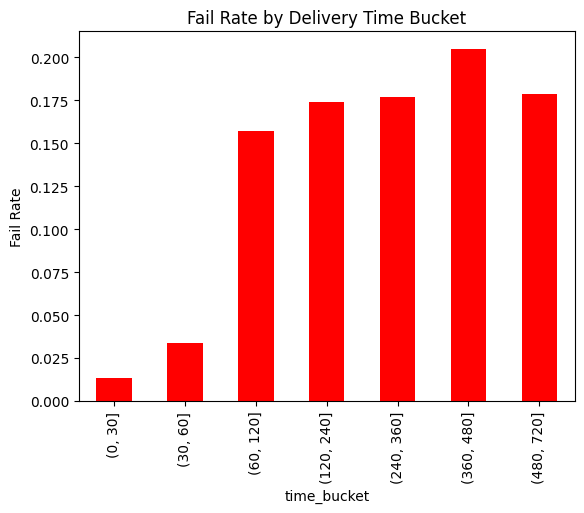

C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:87: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat = df.pivot_table(


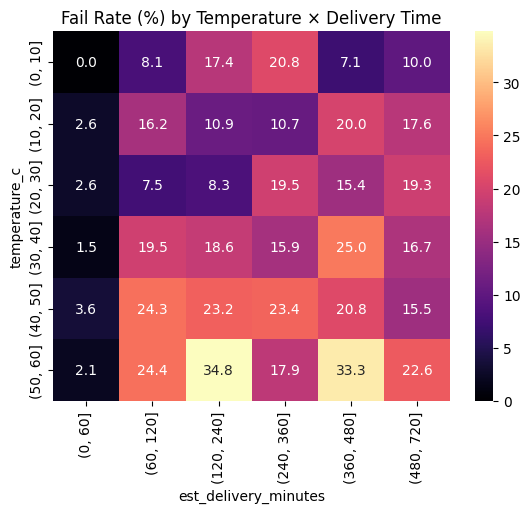

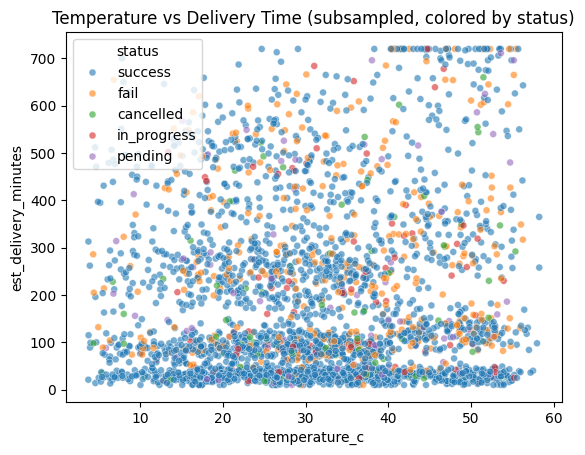

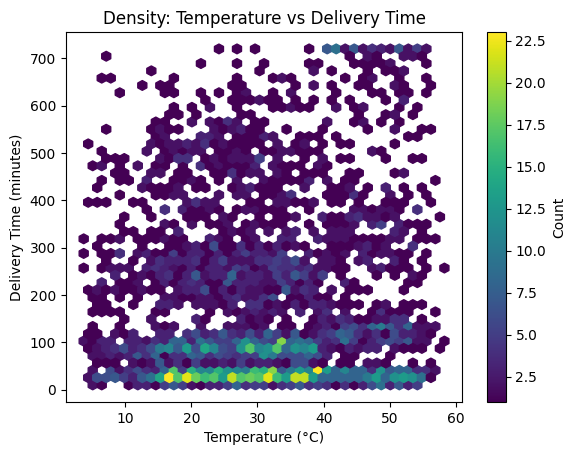

C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:112: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_patients = pd.read_sql("SELECT patient_id, hospital_id FROM Patient", conn)
C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:113: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_prescriptions = pd.read_sql("SELECT prescription_id, medication_id FROM Prescription", conn)
C:\Users\frfqf\AppData\Local\Temp\ipykernel_9008\1618726314.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dash_gps 


Counts per relationship:
GPS per Dashboard (mean): 37.74569495694957
Temp per Dashboard (mean): 37.74569495694957
ETA per Dashboard (mean): 37.74569495694957
Stab per Dashboard (mean): 37.74569495694957

Patients per Hospital:
count     3.000000
mean     28.333333
std      11.239810
min      16.000000
25%      23.500000
50%      31.000000
75%      34.500000
max      38.000000
dtype: float64

Prescriptions per Medication:
count    74.000000
mean      2.864865
std       1.426984
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
dtype: float64


In [ ]:
# %%
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- DB Connection ----------
conn = psycopg2.connect(
    dbname="med_delivery", user="postgres", password="mysecretpassword",
    host="localhost", port="5432"
)

# ---------- Query with aggregates ----------
query = """
WITH temp_avg AS (
  SELECT dashboard_id,
         AVG(CAST(REPLACE(temp_value,' C','') AS FLOAT)) AS temperature_c
  FROM Temperature
  GROUP BY dashboard_id
),
first_eta AS (
  SELECT dashboard_id,
         EXTRACT(EPOCH FROM delay_time)/60.0 AS est_delivery_minutes
  FROM (
    SELECT dashboard_id, delay_time, recorded_at,
           ROW_NUMBER() OVER (PARTITION BY dashboard_id ORDER BY recorded_at ASC) AS rn
    FROM estimated_delivery_time
  ) x WHERE rn = 1
),
stab_avg AS (
  SELECT dashboard_id,
         AVG(EXTRACT(EPOCH FROM stability_time))/3600.0 AS est_stability_hours
  FROM estimated_stability_time
  GROUP BY dashboard_id
)
SELECT o.order_id, o.order_type, o.status, o.priority_level, o.created_at,
       ta.temperature_c, fe.est_delivery_minutes, sa.est_stability_hours
FROM "Order" o
JOIN temp_avg ta ON ta.dashboard_id = o.dashboard_id
JOIN first_eta fe ON fe.dashboard_id = o.dashboard_id
JOIN stab_avg sa ON sa.dashboard_id = o.dashboard_id;
"""
df = pd.read_sql(query, conn)

# ---------- Status distributions ----------
sns.countplot(data=df, x="status")
plt.title("Overall Order Status Distribution")
plt.show()

sns.countplot(data=df, x="order_type", hue="status")
plt.title("Order Type vs Status")
plt.show()

sns.countplot(data=df, x="priority_level", hue="status")
plt.title("Priority vs Status")
plt.show()

# ---------- Temperature & Time impacts ----------
sns.histplot(data=df, x="temperature_c", hue="status", multiple="stack", bins=30)
plt.title("Temperature Impact on Order Status")
plt.show()

sns.histplot(data=df, x="est_delivery_minutes", hue="status", multiple="stack", bins=30)
plt.title("Delivery Time Impact on Status")
plt.show()

# ---------- Success & Fail rate by buckets ----------
df['temp_bucket'] = pd.cut(df['temperature_c'], bins=[0,8,20,30,40,50,60])
df['time_bucket'] = pd.cut(df['est_delivery_minutes'], bins=[0,30,60,120,240,360,480,720])

# Success
success_rate_temp = df.groupby('temp_bucket')['status'].apply(lambda s:(s=="success").mean())
success_rate_time = df.groupby('time_bucket')['status'].apply(lambda s:(s=="success").mean())

success_rate_temp.plot(kind='bar', title="Success Rate by Temperature Bucket"); plt.ylabel("Success Rate"); plt.show()
success_rate_time.plot(kind='bar', title="Success Rate by Delivery Time Bucket"); plt.ylabel("Success Rate"); plt.show()

# Fail
fail_rate_temp = df.groupby('temp_bucket')['status'].apply(lambda s:(s=="fail").mean())
fail_rate_time = df.groupby('time_bucket')['status'].apply(lambda s:(s=="fail").mean())

fail_rate_temp.plot(kind='bar', title="Fail Rate by Temperature Bucket", color="red"); plt.ylabel("Fail Rate"); plt.show()
fail_rate_time.plot(kind='bar', title="Fail Rate by Delivery Time Bucket", color="red"); plt.ylabel("Fail Rate"); plt.show()

# ---------- Heatmap fail rate ----------
df['is_fail'] = (df['status']=="fail").astype(int)
heat = df.pivot_table(
    index=pd.cut(df['temperature_c'], [0,10,20,30,40,50,60]),
    columns=pd.cut(df['est_delivery_minutes'], [0,60,120,240,360,480,720]),
    values='is_fail', aggfunc='mean'
)*100
sns.heatmap(heat, annot=True, fmt=".1f", cmap="magma")
plt.title("Fail Rate (%) by Temperature × Delivery Time")
plt.show()

# ---------- Scatter (subsampled) ----------
df_sample = df.sample(n=min(3000, len(df)), random_state=42)s
sns.scatterplot(data=df_sample, x="temperature_c", y="est_delivery_minutes",
                hue="status", alpha=0.6, s=25)
plt.title("Temperature vs Delivery Time (subsampled, colored by status)")
plt.show()

# ---------- Density hexbin ----------
plt.hexbin(df['temperature_c'], df['est_delivery_minutes'], gridsize=40, cmap="viridis", mincnt=1)
plt.colorbar(label="Count")
plt.xlabel("Temperature (°C)")
plt.ylabel("Delivery Time (minutes)")
plt.title("Density: Temperature vs Delivery Time")
plt.show()

# ---------- Relationship checks ----------
df_patients = pd.read_sql("SELECT patient_id, hospital_id FROM Patient", conn)
df_prescriptions = pd.read_sql("SELECT prescription_id, medication_id FROM Prescription", conn)
df_dash_gps = pd.read_sql("SELECT dashboard_id, gps_id FROM GPS", conn)
df_dash_temp = pd.read_sql("SELECT dashboard_id, temperature_id FROM Temperature", conn)
df_dash_eta = pd.read_sql("SELECT dashboard_id, estimated_delivery_id FROM estimated_delivery_time", conn)
df_dash_stab= pd.read_sql("SELECT dashboard_id, estimated_stability_id FROM estimated_stability_time", conn)
conn.close()

print("\nCounts per relationship:")
print("GPS per Dashboard (mean):",   df_dash_gps.groupby("dashboard_id").size().mean())
print("Temp per Dashboard (mean):",  df_dash_temp.groupby("dashboard_id").size().mean())
print("ETA per Dashboard (mean):",   df_dash_eta.groupby("dashboard_id").size().mean())
print("Stab per Dashboard (mean):",  df_dash_stab.groupby("dashboard_id").size().mean())

print("\nPatients per Hospital:")
print(df_patients.groupby("hospital_id").size().describe())

print("\nPrescriptions per Medication:")
print(df_prescriptions.groupby("medication_id").size().describe())

